In [ ]:
!unzip midi.zip

Archive:  midi.zip
   creating: midi/
  inflating: midi/Very Early solo piano.mid  
  inflating: __MACOSX/midi/._Very Early solo piano.mid  
  inflating: midi/shinystockings.mid  
  inflating: __MACOSX/midi/._shinystockings.mid  
  inflating: midi/I Fall in Love v2.mid  
  inflating: __MACOSX/midi/._I Fall in Love v2.mid  
  inflating: midi/What is this thing - solo.mid  
  inflating: __MACOSX/midi/._What is this thing - solo.mid  
  inflating: midi/Day Dream.mid      
  inflating: __MACOSX/midi/._Day Dream.mid  
  inflating: midi/SweetWay3.mid      
  inflating: __MACOSX/midi/._SweetWay3.mid  
  inflating: midi/something wonderful.mid  
  inflating: __MACOSX/midi/._something wonderful.mid  
  inflating: midi/Where is Love - solo.mid  
  inflating: __MACOSX/midi/._Where is Love - solo.mid  
  inflating: midi/Mean to Me.mid     
  inflating: __MACOSX/midi/._Mean to Me.mid  
  inflating: midi/By The Time.mid    
  inflating: __MACOSX/midi/._By The Time.mid  
  inflating: midi/Stella solo

In [ ]:
!pip install music21
import glob
import pickle
import numpy
import random
from music21 import converter, instrument, note, chord
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

In [ ]:
notes = []
path = "midi"

for file in tqdm(glob.glob(f'{path}/*.mid')):
    rand = random.uniform(0, 1)
    
    # Only train on 25% of the midi set
    if (rand > 0.25):
      continue

    midi = converter.parse(file)
    notes_to_parse = None

    try:    # file has multiple instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

100%|██████████| 144/144 [00:12<00:00, 11.99it/s]


In [ ]:
# Save Notes as Pickle
with open('notes.pkl', 'wb') as note_file:
    pickle.dump(notes, note_file)

In [ ]:
# Load Notes from Pickle
with open('notes.pkl', 'rb') as note_file:
    notes = pickle.load(note_file)

In [ ]:
n_vocab = len(set(notes))
n_vocab

650

In [ ]:
# Set sequence length to 100
sequence_length = 100


pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []


for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

network_output = to_categorical(network_output)

In [ ]:
network_input.shape

(40539, 100, 1)

In [ ]:
network_output.shape

(40539, 650)

In [ ]:
#Create Model
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    recurrent_dropout=0.2,
    return_sequences=True
))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(256))

model.add(BatchNorm())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.2))

model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
activation (Activation)      (None, 128)               0

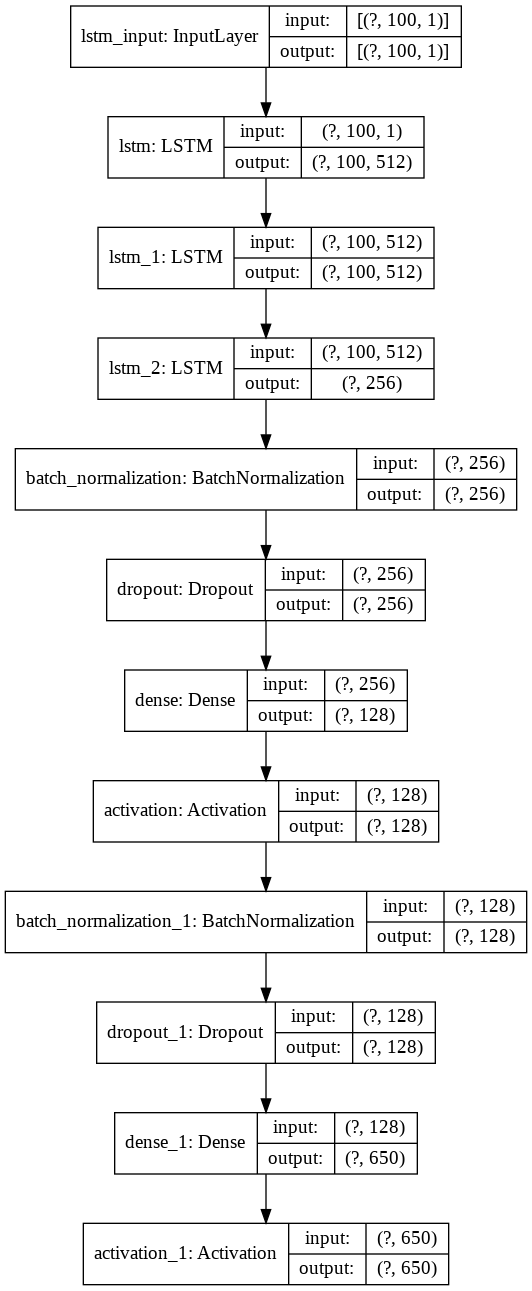

In [ ]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [43]:
# Train Model
#model.load_weights("weights/weights-50.hdf5")

filepath = "weights/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

training_history = model.fit(network_input, network_output, epochs=50, batch_size=128, callbacks=callbacks_list)

Epoch 1/50
317/317 [==============================] - 229s 721ms/step - loss: 5.2992
Epoch 2/50
317/317 [==============================] - 225s 710ms/step - loss: 4.9207
Epoch 3/50
317/317 [==============================] - 227s 717ms/step - loss: 4.8818
Epoch 4/50
317/317 [==============================] - 227s 715ms/step - loss: 4.8771
Epoch 5/50
317/317 [==============================] - 225s 711ms/step - loss: 4.8715
Epoch 6/50
317/317 [==============================] - 224s 705ms/step - loss: 4.8465
Epoch 7/50
317/317 [==============================] - 224s 705ms/step - loss: 4.8352
Epoch 8/50
317/317 [==============================] - 223s 702ms/step - loss: 4.8264
Epoch 9/50
317/317 [==============================] - 219s 691ms/step - loss: 4.8141
Epoch 10/50
317/317 [==============================] - 221s 698ms/step - loss: 4.8201
Epoch 11/50
317/317 [==============================] - 220s 695ms/step - loss: 4.8020
Epoch 12/50
317/317 [==============================] - 222s 700

In [44]:
model.save_weights("weights/weights-50.hdf5")

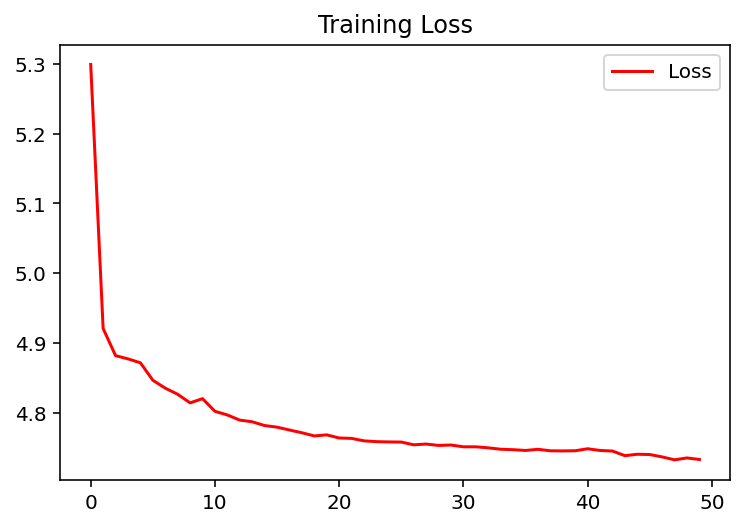

<Figure size 432x288 with 0 Axes>

In [45]:
# Saving plots
import matplotlib.pyplot as plt
import pandas as pd

loss = training_history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# convert the training_history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(training_history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)